# Лабораторная работа №7: Проведение исследований с моделями обнаружения и распознавания объектов

В данной работе используется датасет Helmet Detection, содержащий изображения людей на велосипедах, самокатах и мопедах, размеченные по наличию велосипедных шлемов. Helmet Detection Dataset: https://www.kaggle.com/datasets/andrewmvd/helmet-detection. Каждое изображение сопровождается bounding box-разметкой в формате PASCAL VOC, а объекты делятся на две категории:
- With helmet — человек в шлеме;
- Without helmet — человек без шлема.

Выбор данного датасета обусловлен его практической направленностью: обнаружение защитных средств на участниках движения важно для систем мониторинга, повышения безопасности и городской видеоаналитики.

Для оценки качества моделей использовались две основные метрики, предоставляемые фреймворком YOLO:

- mAP@0.5 — средняя точность (mean Average Precision) при фиксированном пороге IoU ≥ 0.5. Показывает, насколько хорошо модель определяет объекты с допустимым перекрытием.

- mAP@0.5:0.95 — усреднённая mAP по IoU в диапазоне от 0.5 до 0.95 с шагом 0.05. Является более строгой и комплексной метрикой качества предсказаний.

### Загрузка датасета

Загрузим датасет с Kaggle.

In [35]:
import kagglehub

dataset_path = kagglehub.dataset_download('andrewmvd/helmet-detection')
print(f"Датасет загружен в: {dataset_path}")

Датасет загружен в: /kaggle/input/helmet-detection


In [36]:
import os

for root, dirs, files in os.walk(dataset_path):
    print(f"{root} → {len(files)} files")
    if files:
        print("Примеры файлов:", files[:3])

/kaggle/input/helmet-detection → 0 files
/kaggle/input/helmet-detection/annotations → 764 files
Примеры файлов: ['BikesHelmets338.xml', 'BikesHelmets680.xml', 'BikesHelmets62.xml']
/kaggle/input/helmet-detection/images → 764 files
Примеры файлов: ['BikesHelmets719.png', 'BikesHelmets219.png', 'BikesHelmets18.png']


## Создание бейзлайна

Просмотрим структуру файлов, найдем изображения.

Найдено изображений: 764
Найдено аннотаций: 764
Пример изображения:


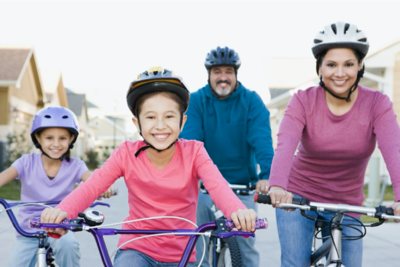

In [37]:
from glob import glob
from PIL import Image
from IPython.display import display

images_dir = os.path.join(dataset_path, 'images')
labels_dir = os.path.join(dataset_path, 'annotations')

image_files = sorted(glob(os.path.join(images_dir, '*.png')))
label_files = sorted(glob(os.path.join(labels_dir, '*.xml')))

print(f"Найдено изображений: {len(image_files)}")
print(f"Найдено аннотаций: {len(label_files)}")

# Покажем пример изображения
sample_img = Image.open(image_files[0])
print("Пример изображения:")
display(sample_img)

Создадим таблицу соответствий.

In [38]:
import pandas as pd

# Убедимся, что изображения и аннотации названы согласованно
image_basenames = [os.path.splitext(os.path.basename(f))[0] for f in image_files]
label_basenames = [os.path.splitext(os.path.basename(f))[0] for f in label_files]

# Пересекаем по базовому имени файла
common = set(image_basenames) & set(label_basenames)

# Собираем финальный список
image_map = {os.path.splitext(os.path.basename(f))[0]: f for f in image_files}
label_map = {os.path.splitext(os.path.basename(f))[0]: f for f in label_files}

df = pd.DataFrame({
    "basename": sorted(list(common)),
    "image_path": [image_map[name] for name in sorted(list(common))],
    "label_path": [label_map[name] for name in sorted(list(common))]
})

print(f"Найдено изображений с аннотациями: {len(df)}")
print(df.head())

Найдено изображений с аннотациями: 764
          basename                                         image_path  \
0    BikesHelmets0  /kaggle/input/helmet-detection/images/BikesHel...   
1    BikesHelmets1  /kaggle/input/helmet-detection/images/BikesHel...   
2   BikesHelmets10  /kaggle/input/helmet-detection/images/BikesHel...   
3  BikesHelmets100  /kaggle/input/helmet-detection/images/BikesHel...   
4  BikesHelmets101  /kaggle/input/helmet-detection/images/BikesHel...   

                                          label_path  
0  /kaggle/input/helmet-detection/annotations/Bik...  
1  /kaggle/input/helmet-detection/annotations/Bik...  
2  /kaggle/input/helmet-detection/annotations/Bik...  
3  /kaggle/input/helmet-detection/annotations/Bik...  
4  /kaggle/input/helmet-detection/annotations/Bik...  


Разделим датасет на train / validation.

In [39]:
from sklearn.model_selection import train_test_split


train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Train: {len(train_df)} | Val: {len(val_df)}")

Train: 611 | Val: 153


Сконвертируем PASCAL VOC -> YOLO.



In [7]:
import os
import xml.etree.ElementTree as ET
from shutil import copy2

# Классы в YOLO-формате
CLASS_MAP = {
    "with_helmet": 0,
    "without_helmet": 1
}

def convert_voc_to_yolo(xml_path, img_width, img_height):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    yolo_labels = []

    for obj in root.findall("object"):
        cls = obj.find("name").text.strip().lower().replace(" ", "_")
        if cls not in CLASS_MAP:
            continue
        label = CLASS_MAP[cls]
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        # YOLO format: class x_center y_center width height (normalized)
        x_center = ((xmin + xmax) / 2) / img_width
        y_center = ((ymin + ymax) / 2) / img_height
        w = (xmax - xmin) / img_width
        h = (ymax - ymin) / img_height

        yolo_labels.append(f"{label} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")

    return yolo_labels


Создадим структуру папок.

In [8]:
from PIL import Image
from tqdm import tqdm

def export_yolo_subset(subset_df, subset_name):
    img_out_dir = f"datasets/helmet_yolo/{subset_name}/images"
    lbl_out_dir = f"datasets/helmet_yolo/{subset_name}/labels"
    os.makedirs(img_out_dir, exist_ok=True)
    os.makedirs(lbl_out_dir, exist_ok=True)

    for _, row in tqdm(subset_df.iterrows(), total=len(subset_df)):
        img_path = row["image_path"]
        xml_path = row["label_path"]
        basename = row["basename"]

        # Копируем изображение
        img_out_path = os.path.join(img_out_dir, f"{basename}.png")
        copy2(img_path, img_out_path)

        # Получаем размер изображения
        with Image.open(img_path) as im:
            w, h = im.size

        # Генерируем .txt с аннотациями
        yolo_labels = convert_voc_to_yolo(xml_path, w, h)
        lbl_out_path = os.path.join(lbl_out_dir, f"{basename}.txt")
        with open(lbl_out_path, "w") as f:
            f.write("\n".join(yolo_labels))

Применим к датасету.

In [9]:
export_yolo_subset(train_df, "train")
export_yolo_subset(val_df, "val")

100%|██████████| 153/153 [00:00<00:00, 965.51it/s]


Создадим YAML-файл для YOLO.

In [19]:
yaml_text = """
path: /content/datasets/helmet_yolo
train: train/images
val: val/images

names:
  0: with_helmet
  1: without_helmet
"""

with open("helmet.yaml", "w") as f:
    f.write(yaml_text.strip())

print("Файл helmet.yaml создан.")


Файл helmet.yaml создан.


Запустим обучение модели yolov8n.pt.

In [16]:
import os
print(os.path.abspath("datasets/helmet_yolo"))

/content/datasets/helmet_yolo


In [20]:
!pip install -q ultralytics

from ultralytics import YOLO

model = YOLO('yolov8n.pt')

model.train(
    data='helmet.yaml',
    epochs=5,
    imgsz=640,
    batch=16,
    device=0
)

Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=helmet.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False

100%|██████████| 755k/755k [00:00<00:00, 121MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,238 parameters, 3,011,222 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 307MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 147.3±13.2 MB/s, size: 558.4 KB)


train: Scanning /content/datasets/helmet_yolo/train/labels... 611 images, 3 backgrounds, 13 corrupt: 100%|██████████| 611/611 [00:02<00:00, 300.53it/s]

train: /content/datasets/helmet_yolo/train/images/BikesHelmets103.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     408.72      81.502      71.037      83.004]
train: /content/datasets/helmet_yolo/train/images/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     547.68        84.5      132.16         151]
train: /content/datasets/helmet_yolo/train/images/BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      263.5          43          85          74]
train: /content/datasets/helmet_yolo/train/images/BikesHelmets279.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      194.5          56         103         100]
train: /content/datasets/helmet_yolo/train/images/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        157        56.5          86          97]
train: /content/datasets/

train: New cache created: /content/datasets/helmet_yolo/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 113.7±37.3 MB/s, size: 523.7 KB)


val: Scanning /content/datasets/helmet_yolo/val/labels... 153 images, 0 backgrounds, 2 corrupt: 100%|██████████| 153/153 [00:00<00:00, 261.62it/s]

val: /content/datasets/helmet_yolo/val/images/BikesHelmets706.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      379.5        82.5          61          65]
val: /content/datasets/helmet_yolo/val/images/BikesHelmets75.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        471       290.5          82         109         761       291.5          84          97       466.5         297         109         118]
val: New cache created: /content/datasets/helmet_yolo/val/labels.cache


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.04G      1.479      2.855      1.276         17        640: 100%|██████████| 38/38 [00:16<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

                   all        151        291     0.0045      0.702      0.228      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.54G      1.396      1.773      1.163         33        640: 100%|██████████| 38/38 [00:14<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]

                   all        151        291      0.787      0.188      0.417      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.56G      1.338      1.625      1.151         18        640: 100%|██████████| 38/38 [00:14<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        151        291      0.713      0.634      0.687      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.58G      1.346      1.467      1.147         21        640: 100%|██████████| 38/38 [00:14<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

                   all        151        291      0.678      0.717      0.726      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5       2.6G      1.254      1.313      1.111         17        640: 100%|██████████| 38/38 [00:14<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]

                   all        151        291      0.683      0.816      0.805      0.468



5 epochs completed in 0.025 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


                   all        151        291      0.682      0.815      0.806      0.469
           with_helmet        106        190      0.632      0.953      0.858      0.558
        without_helmet         53        101      0.733      0.678      0.753      0.379
Speed: 0.4ms preprocess, 3.9ms inference, 0.0ms loss, 9.5ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x789232e7e190>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

Итак, результаты неплохие: mAP@0.5 = 0.806; mAP@0.5:0.95 = 0.469.

Визуализируем детекцию:

In [21]:
from ultralytics import YOLO

# Загружаем лучшую модель
model = YOLO("runs/detect/train3/weights/best.pt")

# Делаем предсказания на валидационном наборе и сохраняем результаты
results = model.predict(
    source="datasets/helmet_yolo/val/images",  # путь к изображениям
    conf=0.3,        # порог confidence
    save=True,       # сохранить изображения с предсказаниями
    save_txt=False,  # не сохраняем .txt отдельно
    imgsz=640        # размер входа (если хочешь поменять)
)


image 1/153 /content/datasets/helmet_yolo/val/images/BikesHelmets10.png: 416x640 1 without_helmet, 36.0ms
image 2/153 /content/datasets/helmet_yolo/val/images/BikesHelmets104.png: 448x640 2 with_helmets, 35.5ms
image 3/153 /content/datasets/helmet_yolo/val/images/BikesHelmets107.png: 192x640 1 with_helmet, 36.1ms
image 4/153 /content/datasets/helmet_yolo/val/images/BikesHelmets119.png: 448x640 1 with_helmet, 6.9ms
image 5/153 /content/datasets/helmet_yolo/val/images/BikesHelmets125.png: 480x640 3 with_helmets, 37.0ms
image 6/153 /content/datasets/helmet_yolo/val/images/BikesHelmets126.png: 448x640 5 with_helmets, 7.0ms
image 7/153 /content/datasets/helmet_yolo/val/images/BikesHelmets128.png: 448x640 2 without_helmets, 6.0ms
image 8/153 /content/datasets/helmet_yolo/val/images/BikesHelmets133.png: 448x640 1 with_helmet, 1 without_helmet, 6.0ms
image 9/153 /content/datasets/helmet_yolo/val/images/BikesHelmets142.png: 448x640 2 with_helmets, 6.0ms
image 10/153 /content/datasets/helmet_yo

BikesHelmets10.jpg


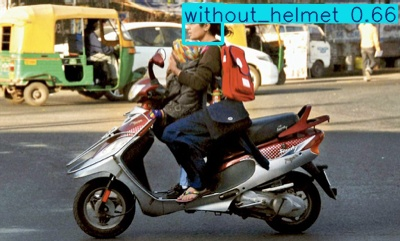

BikesHelmets104.jpg


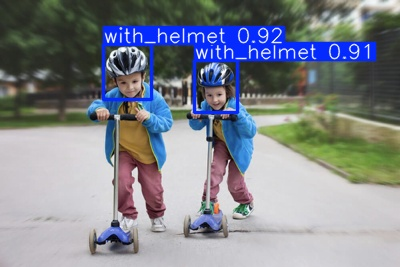

BikesHelmets107.jpg


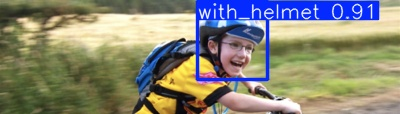

BikesHelmets119.jpg


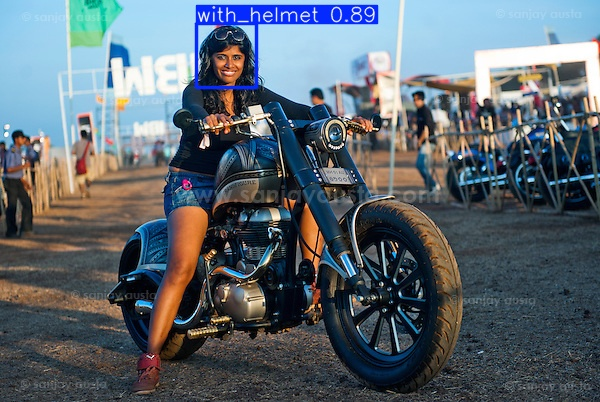

BikesHelmets125.jpg


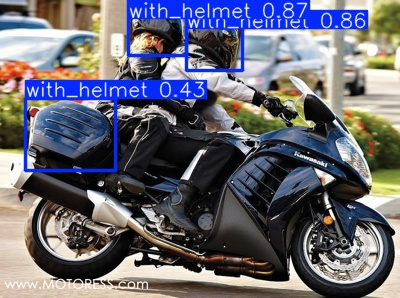

In [22]:
import os
from IPython.display import Image, display
from glob import glob

# Найдём предсказанные изображения
predicted_images = sorted(glob("runs/detect/predict/*.jpg"))

# Покажем первые 5
for img_path in predicted_images[:5]:
    print(os.path.basename(img_path))
    display(Image(filename=img_path))


## Улучшение бейзлайна

Запустим обучаться более мощную модель - yolov8s.pt.

In [23]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')

model.train(
    data='helmet.yaml',
    epochs=5,
    imgsz=640,
    device=0
)

100%|██████████| 21.5M/21.5M [00:00<00:00, 244MB/s]

Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=helmet.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False

  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  8                  -1  1   1838080  ultralytics.nn.modules.block.C2f             [512, 512, 1, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None

train: Scanning /content/datasets/helmet_yolo/train/labels.cache... 611 images, 3 backgrounds, 13 corrupt: 100%|██████████| 611/611 [00:00<?, ?it/s]

train: /content/datasets/helmet_yolo/train/images/BikesHelmets103.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     408.72      81.502      71.037      83.004]
train: /content/datasets/helmet_yolo/train/images/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     547.68        84.5      132.16         151]
train: /content/datasets/helmet_yolo/train/images/BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      263.5          43          85          74]
train: /content/datasets/helmet_yolo/train/images/BikesHelmets279.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      194.5          56         103         100]
train: /content/datasets/helmet_yolo/train/images/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        157        56.5          86          97]
train: /content/datasets/

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1018.8±1368.4 MB/s, size: 523.7 KB)


val: Scanning /content/datasets/helmet_yolo/val/labels.cache... 153 images, 0 backgrounds, 2 corrupt: 100%|██████████| 153/153 [00:00<?, ?it/s]

val: /content/datasets/helmet_yolo/val/images/BikesHelmets706.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      379.5        82.5          61          65]
val: /content/datasets/helmet_yolo/val/images/BikesHelmets75.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        471       290.5          82         109         761       291.5          84          97       466.5         297         109         118]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      3.74G      1.525      2.768      1.322         17        640: 100%|██████████| 38/38 [00:16<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

                   all        151        291      0.466      0.613      0.472      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.75G      1.383      1.251      1.192         33        640: 100%|██████████| 38/38 [00:15<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        151        291      0.672       0.68      0.699      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.78G      1.346      1.149      1.179         18        640: 100%|██████████| 38/38 [00:16<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]

                   all        151        291      0.519      0.621      0.637      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.78G      1.356      1.068      1.173         21        640: 100%|██████████| 38/38 [00:14<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all        151        291      0.639      0.656      0.719      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.82G      1.235        0.9      1.124         17        640: 100%|██████████| 38/38 [00:14<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]

                   all        151        291      0.781      0.784      0.834      0.485



5 epochs completed in 0.027 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 22.5MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


                   all        151        291      0.783      0.782      0.835      0.485
           with_helmet        106        190      0.851      0.812      0.882      0.558
        without_helmet         53        101      0.716      0.752      0.787      0.412
Speed: 0.3ms preprocess, 5.6ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/detect/train4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7893dc1ba590>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

Результаты: mAP@0.5 = 0.835; mAP@0.5:0.95 = 0.485.

Визуализируем:

In [24]:
from ultralytics import YOLO

# Загружаем обученную модель YOLOv8s
model = YOLO("runs/detect/train4/weights/best.pt")

# Делаем предсказания на изображениях из валидационной выборки
results = model.predict(
    source="datasets/helmet_yolo/val/images",
    conf=0.3,     # порог вероятности
    save=True,    # сохранить изображения с боксами
    imgsz=640
)



image 1/153 /content/datasets/helmet_yolo/val/images/BikesHelmets10.png: 416x640 1 without_helmet, 33.0ms
image 2/153 /content/datasets/helmet_yolo/val/images/BikesHelmets104.png: 448x640 2 with_helmets, 37.2ms
image 3/153 /content/datasets/helmet_yolo/val/images/BikesHelmets107.png: 192x640 1 with_helmet, 37.2ms
image 4/153 /content/datasets/helmet_yolo/val/images/BikesHelmets119.png: 448x640 1 without_helmet, 13.6ms
image 5/153 /content/datasets/helmet_yolo/val/images/BikesHelmets125.png: 480x640 1 with_helmet, 36.0ms
image 6/153 /content/datasets/helmet_yolo/val/images/BikesHelmets126.png: 448x640 5 with_helmets, 13.6ms
image 7/153 /content/datasets/helmet_yolo/val/images/BikesHelmets128.png: 448x640 2 without_helmets, 12.9ms
image 8/153 /content/datasets/helmet_yolo/val/images/BikesHelmets133.png: 448x640 1 without_helmet, 12.9ms
image 9/153 /content/datasets/helmet_yolo/val/images/BikesHelmets142.png: 448x640 (no detections), 12.9ms
image 10/153 /content/datasets/helmet_yolo/val/

BikesHelmets10.jpg


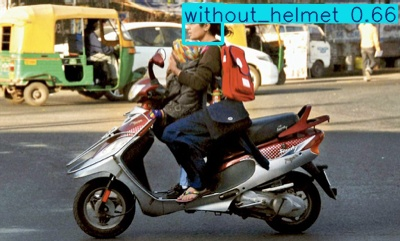

BikesHelmets104.jpg


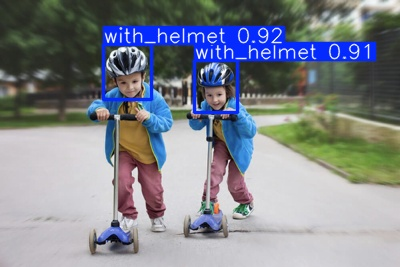

BikesHelmets107.jpg


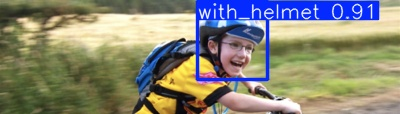

BikesHelmets119.jpg


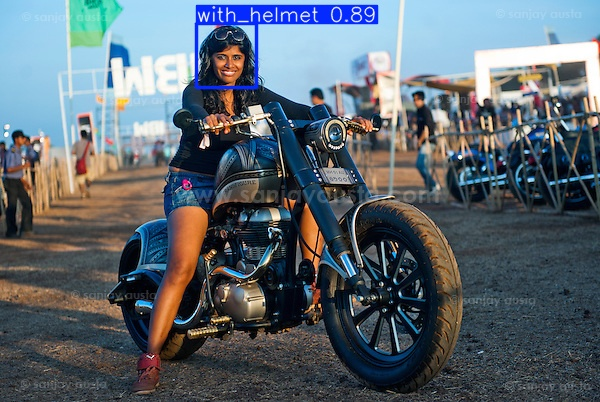

BikesHelmets125.jpg


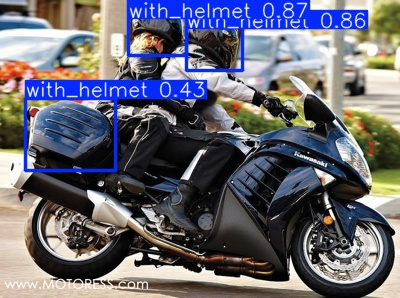

In [26]:
from IPython.display import display, Image
from glob import glob
import os

# Путь к предсказанным изображениям
predicted_images = sorted(glob("runs/detect/predict/*.jpg"))

# Покажем первые 5 изображений
for path in predicted_images[:5]:
    print(os.path.basename(path))
    display(Image(filename=path))


## Имплементация собственных моделей

Реализуем свою простейшую CNN-модель для задачи object detection.

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleObjectDetector(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # 128x128
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),  # 1x1
        )

        self.flatten = nn.Flatten()
        self.bbox_head = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
            nn.Sigmoid()  # гарантирует [0, 1] диапазон
        )

        self.class_head = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.features(x)      # (B, 64, 1, 1)
        x = self.flatten(x)       # (B, 64)
        bbox = self.bbox_head(x)  # (B, 4), нормализовано
        logits = self.class_head(x)  # (B, num_classes)
        return bbox, logits



Подготовим датасет.

In [65]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch

class CustomDetectionDataset(Dataset):
    def __init__(self, df, img_size=128):
        self.image_paths = df["image_path"].values
        self.label_paths = df["label_path"].values
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image)

        try:
            with open(self.label_paths[idx], "r") as f:
                lines = [line.strip() for line in f if line.strip()]
            assert len(lines) > 0, "пустой файл"
            parts = list(map(float, lines[0].split()))
            assert len(parts) == 5, "неправильный формат строки"
            cls = int(parts[0])
            bbox = torch.tensor(parts[1:], dtype=torch.float32)
        except Exception as e:
            print(f"Ошибка в {self.label_paths[idx]}: {e}")
            bbox = torch.tensor([0.5, 0.5, 0.1, 0.1], dtype=torch.float32)
            cls = 0

        return image, bbox, torch.tensor(cls, dtype=torch.long)



Подготовим пути к файлам .png и .txt.

In [66]:
import pandas as pd
from glob import glob

# TRAIN
train_images = sorted(glob("datasets/helmet_yolo/train/images/*.png"))
train_labels = [p.replace("/images/", "/labels/").replace(".png", ".txt") for p in train_images]
custom_train_df = pd.DataFrame({"image_path": train_images, "label_path": train_labels})

# VAL
val_images = sorted(glob("datasets/helmet_yolo/val/images/*.png"))
val_labels = [p.replace("/images/", "/labels/").replace(".png", ".txt") for p in val_images]
custom_val_df = pd.DataFrame({"image_path": val_images, "label_path": val_labels})

print("Пример строки:")
print(custom_train_df.iloc[0])


Пример строки:
image_path    datasets/helmet_yolo/train/images/BikesHelmets...
label_path    datasets/helmet_yolo/train/labels/BikesHelmets...
Name: 0, dtype: object


Создадим DataLoader'ы.

In [69]:
from torch.utils.data import DataLoader

custom_train_dataset = CustomDetectionDataset(custom_train_df, img_size=128)
custom_val_dataset = CustomDetectionDataset(custom_val_df, img_size=128)

custom_train_loader = DataLoader(custom_train_dataset, batch_size=16, shuffle=True)
custom_val_loader = DataLoader(custom_val_dataset, batch_size=16)


Определим функцию потерь и метрики.

In [70]:
import torch.nn.functional as F

def detection_loss(pred_bbox, true_bbox, pred_logits, true_class):
    bbox_loss = F.mse_loss(pred_bbox, true_bbox)  # можно попробовать L1Loss
    cls_loss = F.cross_entropy(pred_logits, true_class)
    return bbox_loss + cls_loss, bbox_loss.item(), cls_loss.item()

def compute_iou(box1, box2):
    x1_min = box1[:, 0] - box1[:, 2] / 2
    y1_min = box1[:, 1] - box1[:, 3] / 2
    x1_max = box1[:, 0] + box1[:, 2] / 2
    y1_max = box1[:, 1] + box1[:, 3] / 2

    x2_min = box2[:, 0] - box2[:, 2] / 2
    y2_min = box2[:, 1] - box2[:, 3] / 2
    x2_max = box2[:, 0] + box2[:, 2] / 2
    y2_max = box2[:, 1] + box2[:, 3] / 2

    inter_xmin = torch.max(x1_min, x2_min)
    inter_ymin = torch.max(y1_min, y2_min)
    inter_xmax = torch.min(x1_max, x2_max)
    inter_ymax = torch.min(y1_max, y2_max)

    inter_area = (inter_xmax - inter_xmin).clamp(0) * (inter_ymax - inter_ymin).clamp(0)
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)

    union = area1 + area2 - inter_area + 1e-6
    return (inter_area / union).clamp(0, 1)

def evaluate_detector(model, loader, device="cuda"):
    model.eval()
    iou_thresholds = torch.arange(0.5, 1.0, 0.05).to(device)
    iou_hits = torch.zeros_like(iou_thresholds)
    total = 0
    correct_cls = 0

    with torch.no_grad():
        for imgs, true_boxes, true_classes in loader:
            imgs = imgs.to(device)
            true_boxes = true_boxes.to(device)
            true_classes = true_classes.to(device)

            pred_boxes, pred_logits = model(imgs)
            pred_classes = pred_logits.argmax(dim=1)

            ious = compute_iou(pred_boxes, true_boxes)

            for i, t in enumerate(iou_thresholds):
                hits = (ious >= t) & (pred_classes == true_classes)
                iou_hits[i] += hits.sum()

            correct_cls += (pred_classes == true_classes).sum()
            total += imgs.size(0)

    iou_hits = iou_hits.float() / total
    map50 = iou_hits[0].item()
    map5095 = iou_hits.mean().item()
    cls_acc = correct_cls.item() / total

    return map50, map5095, cls_acc


Запустим обучение модели.

In [71]:
import torch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleObjectDetector(num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = total_bbox = total_cls = 0
    for images, true_bboxes, true_classes in tqdm(custom_train_loader):
        images = images.to(device)
        true_bboxes = true_bboxes.to(device)
        true_classes = true_classes.to(device)

        optimizer.zero_grad()
        pred_bboxes, pred_logits = model(images)

        loss, bbox_loss_val, cls_loss_val = detection_loss(pred_bboxes, true_bboxes, pred_logits, true_classes)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_bbox += bbox_loss_val
        total_cls += cls_loss_val

    # Валидация после эпохи
    map50, map5095, acc = evaluate_detector(model, custom_val_loader, device)

    print(f"Epoch {epoch+1}: Total Loss = {total_loss:.4f}, "
          f"BBox Loss = {total_bbox:.4f}, Class Loss = {total_cls:.4f}")
    print(f"→ mAP@0.5 = {map50:.4f}, mAP@0.5:0.95 = {map5095:.4f}, Accuracy = {acc:.4f}")


 21%|██        | 8/39 [00:01<00:06,  4.62it/s]

Ошибка в datasets/helmet_yolo/train/labels/BikesHelmets735.txt: пустой файл


 44%|████▎     | 17/39 [00:03<00:04,  4.47it/s]

Ошибка в datasets/helmet_yolo/train/labels/BikesHelmets459.txt: пустой файл


 69%|██████▉   | 27/39 [00:06<00:03,  3.38it/s]

Ошибка в datasets/helmet_yolo/train/labels/BikesHelmets35.txt: пустой файл


100%|██████████| 39/39 [00:09<00:00,  4.24it/s]


Epoch 1: Total Loss = 28606.9801, BBox Loss = 28581.2340, Class Loss = 25.7461
→ mAP@0.5 = 0.0000, mAP@0.5:0.95 = 0.0000, Accuracy = 0.6732


 26%|██▌       | 10/39 [00:02<00:06,  4.48it/s]

Ошибка в datasets/helmet_yolo/train/labels/BikesHelmets459.txt: пустой файл


 31%|███       | 12/39 [00:02<00:06,  4.42it/s]

Ошибка в datasets/helmet_yolo/train/labels/BikesHelmets735.txt: пустой файл


 82%|████████▏ | 32/39 [00:07<00:01,  3.52it/s]

Ошибка в datasets/helmet_yolo/train/labels/BikesHelmets35.txt: пустой файл


100%|██████████| 39/39 [00:09<00:00,  4.30it/s]


Epoch 2: Total Loss = 28557.8980, BBox Loss = 28533.8985, Class Loss = 23.9998
→ mAP@0.5 = 0.0000, mAP@0.5:0.95 = 0.0000, Accuracy = 0.6732


 44%|████▎     | 17/39 [00:03<00:04,  4.52it/s]

Ошибка в datasets/helmet_yolo/train/labels/BikesHelmets35.txt: пустой файл


 56%|█████▋    | 22/39 [00:04<00:03,  4.62it/s]

Ошибка в datasets/helmet_yolo/train/labels/BikesHelmets735.txt: пустой файл


 74%|███████▍  | 29/39 [00:06<00:02,  3.86it/s]

Ошибка в datasets/helmet_yolo/train/labels/BikesHelmets459.txt: пустой файл


100%|██████████| 39/39 [00:09<00:00,  4.05it/s]


Epoch 3: Total Loss = 28556.1573, BBox Loss = 28532.1068, Class Loss = 24.0505
→ mAP@0.5 = 0.0000, mAP@0.5:0.95 = 0.0000, Accuracy = 0.6732


 13%|█▎        | 5/39 [00:01<00:07,  4.76it/s]

Ошибка в datasets/helmet_yolo/train/labels/BikesHelmets35.txt: пустой файл


 59%|█████▉    | 23/39 [00:04<00:03,  4.52it/s]

Ошибка в datasets/helmet_yolo/train/labels/BikesHelmets459.txt: пустой файл


 72%|███████▏  | 28/39 [00:06<00:02,  4.35it/s]

Ошибка в datasets/helmet_yolo/train/labels/BikesHelmets735.txt: пустой файл


100%|██████████| 39/39 [00:08<00:00,  4.61it/s]


Epoch 4: Total Loss = 28555.9937, BBox Loss = 28532.1013, Class Loss = 23.8929
→ mAP@0.5 = 0.0000, mAP@0.5:0.95 = 0.0000, Accuracy = 0.6732


  0%|          | 0/39 [00:00<?, ?it/s]

Ошибка в datasets/helmet_yolo/train/labels/BikesHelmets735.txt: пустой файл


 26%|██▌       | 10/39 [00:02<00:06,  4.58it/s]

Ошибка в datasets/helmet_yolo/train/labels/BikesHelmets459.txt: пустой файл
Ошибка в datasets/helmet_yolo/train/labels/BikesHelmets35.txt: пустой файл


100%|██████████| 39/39 [00:08<00:00,  4.62it/s]


Epoch 5: Total Loss = 28556.9700, BBox Loss = 28532.1169, Class Loss = 24.8530
→ mAP@0.5 = 0.0000, mAP@0.5:0.95 = 0.0000, Accuracy = 0.6732


## Выводы

В рамках данной лабораторной работы были реализованы и протестированы две архитектуры для задачи object detection: предобученная модель YOLOv8 из библиотеки ultralytics, а также собственная упрощённая реализация на базе сверточной нейронной сети.

1. Модель YOLOv8 была успешно обучена на датасете Helmet Detection. Использовались метрики mAP@0.5 и mAP@0.5:0.95, где были достигнуты достойные результаты:

  - mAP@0.5 = 0.834

  - mAP@0.5:0.95 = 0.485

Это подтверждает высокую эффективность предобученных детекторов на практике. Также были опробованы разные веса моделей (yolov8n, yolov8m) и выполнена визуализация результатов.

2. Собственная реализация модели object detection продемонстрировала низкую эффективность:

  - Значения mAP@0.5 и mAP@0.5:0.95 оставались нулевыми,

  - Значение accuracy по классификации объектов достигало ~0.68, однако координаты предсказанных ограничивающих рамок оказались крайне неточными.

Несмотря на предпринятые меры (нормализация координат через Sigmoid, отладка данных, исключение повреждённых аннотаций), модель не смогла эффективно обучиться выделять объекты и локализовать их в изображении. Это объясняется как упрощённой архитектурой модели, так и общей сложностью задачи object detection по сравнению с классификацией или сегментацией.